In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
import xgboost

pd.options.display.max_columns = None

# Dataset Selection

In [2]:
# https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices/
dtf = pd.read_csv("./ndtv_data_final.csv",index_col='Unnamed: 0')

In [3]:
# convert Yes/No columns to binary 1/0
dtf['Touchscreen']= dtf['Touchscreen'].map(dict(Yes=1, No=0))
dtf['Wi-Fi']= dtf['Wi-Fi'].map(dict(Yes=1, No=0))
dtf['Bluetooth']= dtf['Bluetooth'].map(dict(Yes=1, No=0))
dtf['GPS']= dtf['GPS'].map(dict(Yes=1, No=0))
dtf['3G']= dtf['3G'].map(dict(Yes=1, No=0))
dtf['4G/ LTE']= dtf['4G/ LTE'].map(dict(Yes=1, No=0))
# Price is given in Indian Rupee, convert to USD based on today exchange rate
dtf['Price']= dtf['Price'] * 0.012

In [4]:
# dtf['Android_OS'] = 0
# dtf.loc[dtf['Operating system'] == 'Android', 'Android_OS'] = 1
# dtf['iOS'] = 0
# dtf.loc[dtf['Operating system'] == 'iOS', 'iOS'] = 1


In [5]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1358
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1359 non-null   object 
 1   Brand                   1359 non-null   object 
 2   Model                   1359 non-null   object 
 3   Battery capacity (mAh)  1359 non-null   int64  
 4   Screen size (inches)    1359 non-null   float64
 5   Touchscreen             1359 non-null   int64  
 6   Resolution x            1359 non-null   int64  
 7   Resolution y            1359 non-null   int64  
 8   Processor               1359 non-null   int64  
 9   RAM (MB)                1359 non-null   int64  
 10  Internal storage (GB)   1359 non-null   float64
 11  Rear camera             1359 non-null   float64
 12  Front camera            1359 non-null   float64
 13  Operating system        1359 non-null   object 
 14  Wi-Fi                   1359 non-null   int64

In [6]:
dtf.head()

,Name,Brand,Model,Battery capacity (mAh),Screen size (inches),Touchscreen,Resolution x,Resolution y,Processor,RAM (MB),Internal storage (GB),Rear camera,Front camera,Operating system,Wi-Fi,Bluetooth,GPS,Number of SIMs,3G,4G/ LTE,Price
0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,1,1440,3120,8,12000,256.0,48.0,16.0,Android,1,1,1,2,1,1,707.976
1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,1,1080,2400,8,6000,64.0,64.0,16.0,Android,1,1,1,2,1,1,335.988
2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,1,1242,2688,6,4000,64.0,12.0,12.0,iOS,1,1,1,2,1,1,1282.800
3,iPhone 11,Apple,iPhone 11,3110,6.10,1,828,1792,6,4000,64.0,12.0,12.0,iOS,1,1,1,2,1,1,754.800
4,LG G8X ThinQ,LG,G8X ThinQ,4000,6.40,1,1080,2340,8,6000,128.0,12.0,32.0,Android,1,1,1,1,0,0,599.880


In [7]:
numeric_cols = [x for x in dtf.columns if dtf[x].dtype == 'int64' or dtf[x].dtype == 'float64']

# Data Analysis Visuals

## 1. Target Histogram & KDE

Text(0.5, 1.0, 'Target Histogram & KDE')

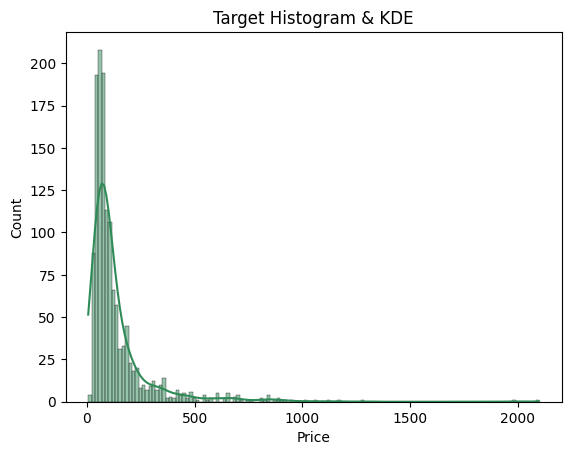

In [8]:
sns.histplot(dtf['Price'], kde=True,color="seagreen").set_title("Target Histogram & KDE")

In this visual, we can see the distribution of target variable (Price). We can learn that our data is skewd to the left. In addition we see that most of the phones (in the dataset) are low-priced phones (close to zero). This information will be useful when error analyzing our model, focusing on the model's error at the lower end of Price (we want to build a model that works for the "normal" data, not the outliers).

## 2. Target Boxplot by OS

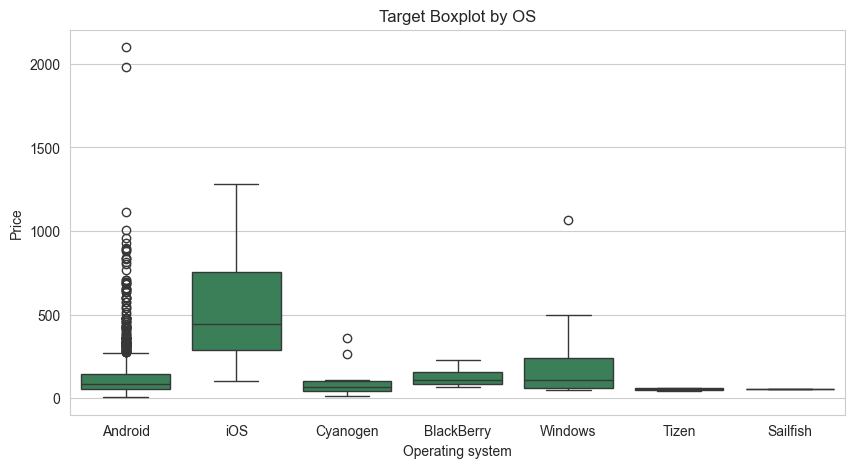

In [9]:
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
box_plot = sns.boxplot(data=dtf,x='Operating system', y='Price',color="seagreen").set_title("Target Boxplot by OS")

In this visual, we can see the distribution of target variable (Price) in each of the 7 different OS. We can see that the vast majority of the outliers are in Android OS. Meaning, we should consider creating a binary feature "Has_Android_OS" so our model will know to recognize the outliers and treat them as needed. In addition, we can learn from the visual that some OS share similarity in the Price range (such as Cyanogen and BlackBerry), encouraging us to group them later when trying to improve the model.

## 3. Features Correlation with target

Text(0.5, 1.0, 'Target Boxplot by OS')

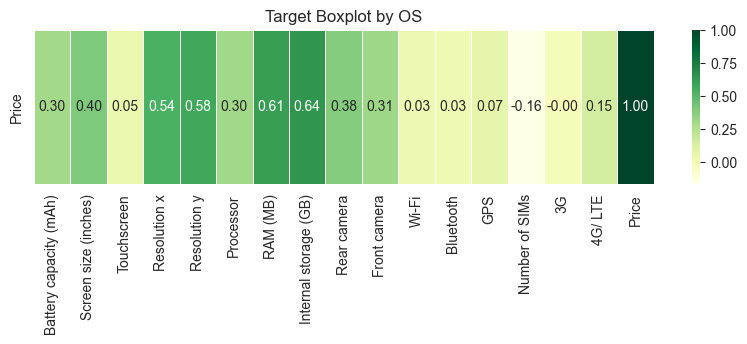

In [10]:
dtf_corr = dtf[numeric_cols].corr(method="pearson").loc[["Price"]]
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f',cmap='YlGn', cbar=True, linewidths=0.5,ax=ax).set_title("Target Boxplot by OS")

In this visual, we can see how the different (numerical) features are correlated to the target variable (Price).Using that information we can get a good understanding about which features can explain the price value and focus on them. In our example, we can see that the most exlpanatory numerical variables are RAM, Storage and Screen (resolution/size). This information follows the intuition that the more expensive the hardware parts are, the more expensive the phone gets.

## 4. Diagonal Correlation Matrix

Text(0.5, 1.0, 'Diagonal Correlation Matrix')

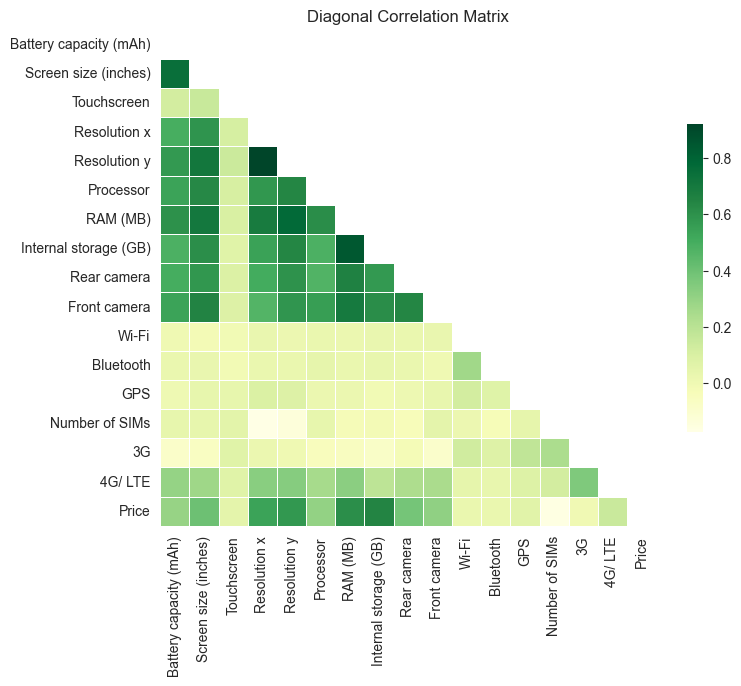

In [11]:
dtf_corr = dtf[numeric_cols].corr()
mask = np.triu(np.ones_like(dtf_corr, dtype=bool))
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(dtf_corr, mask=mask, cmap='YlGn',  square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Diagonal Correlation Matrix")

In this visual, we can see the correlation between our numerical features (without duplicates). Judging by the "browness" of the matrix, we learn that most of our "hardware features" are correlated to each other. This comes with no surprise as phone manufactors are usually trying to manufactor "uniform phones", meaning that if a phone has one high-end hardware part (such as an expensive camera) than it will usually also have high end CPU,RAM etc. Ofcourse the opposite is also true (one low-end hardware part implies other low-end parts), hence the correlation. We will use this information when trying to improve our model, removing unccesseary correlated features.

## 5. Battery Capacity-Price Relation

In [12]:
dtf_corr = dtf[numeric_cols].corr(method="pearson").loc[["Price"]]
print(f'Battery capacity (mAh) - Price correlation (Pearson):{dtf_corr["""Battery capacity (mAh)"""].iloc[0]}')

Battery capacity (mAh) - Price correlation (Pearson):0.29752517571310566


Seems a pretty low correlation, how isn't it that bigger battery implies higher price?
Let's investigate further:

C:\Users\eldor\AppData\Local\Temp\ipykernel_3616\4209431633.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dtf_battery_price = dtf.groupby(pd.cut(dtf['Battery capacity (mAh)'],7))['Price'].mean()
C:\Users\eldor\AppData\Local\Temp\ipykernel_3616\4209431633.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


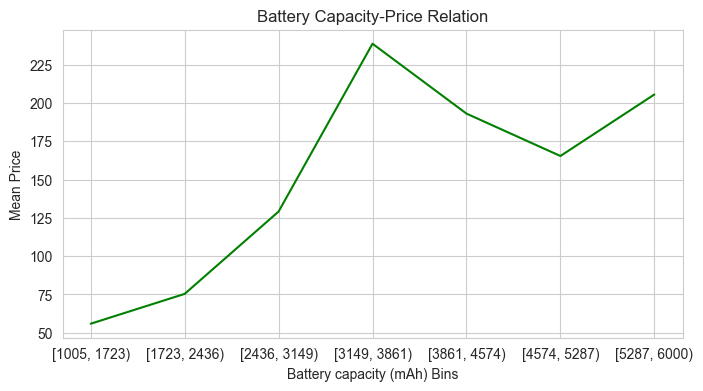

In [13]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,4))
dtf_battery_price = dtf.groupby(pd.cut(dtf['Battery capacity (mAh)'],7))['Price'].mean()
l = dtf_battery_price.index.categories.left.map("{:.0f}".format)
r = dtf_battery_price.index.categories.right.map("{:.0f}".format)
xticklabels = ['0'] + list('['+l+', '+r+')') # adding '0' as a place holder for zero tick label
plt.plot(range(len(dtf_battery_price)), dtf_battery_price.values,color='green')

ax.set_xticklabels(xticklabels)
ax.set_xlabel("Battery capacity (mAh) Bins")
ax.set_ylabel("Mean Price")
ax.set_title("Battery Capacity-Price Relation")

plt.show()

In this visual, we can see that there is a correlation bewteen battery capacity and price, but its not an immideate correlation like other features. At first, we need to split the battery capacity to bins. Then, we see that there is a positive correlation until the 4000mAh values, a negative correlation from 4000 to 5000 and finally an additional positive correlation starting at 5000mAh. We can use this new understanding and split the battery capacity feature to 3 different features: x<4000,4000<x<5000 and x>5000 in order to improve our model.

# Basic Model Pipeline

## Train / Test Split

In [14]:
# train/test split
dtf_train, dtf_test = train_test_split(dtf, test_size=0.25,random_state=10)

Text(0.5, 1.0, 'Battery Capacity-Price Relation')

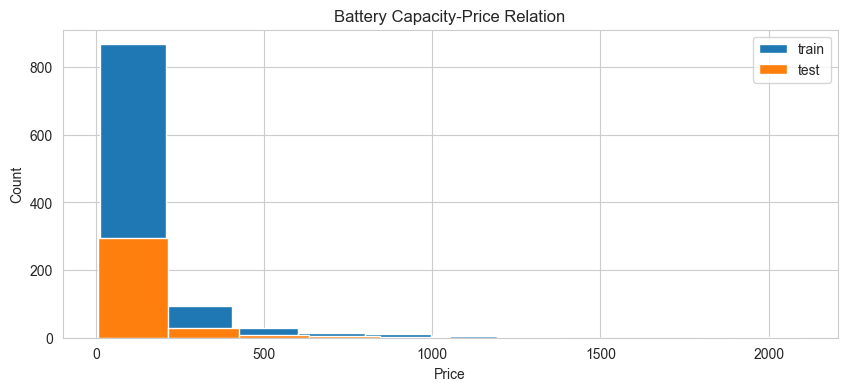

In [15]:
# ensure split representation of the target
fig, ax = plt.subplots(figsize=(10,4))
dtf_train['Price'].hist(ax=ax)
dtf_test['Price'].hist(ax=ax)
ax.legend(["train", "test"])
ax.set_title("Price Histogram")
ax.set_xlabel("Price")
ax.set_ylabel("Count")
ax.set_title("Battery Capacity-Price Relation")

## NULLs

In [16]:
display(dtf_train.isna().sum())
display(dtf_test.isna().sum())

Name                      0
Brand                     0
Model                     0
Battery capacity (mAh)    0
Screen size (inches)      0
Touchscreen               0
Resolution x              0
Resolution y              0
Processor                 0
RAM (MB)                  0
Internal storage (GB)     0
Rear camera               0
Front camera              0
Operating system          0
Wi-Fi                     0
Bluetooth                 0
GPS                       0
Number of SIMs            0
3G                        0
4G/ LTE                   0
Price                     0
dtype: int64

Name                      0
Brand                     0
Model                     0
Battery capacity (mAh)    0
Screen size (inches)      0
Touchscreen               0
Resolution x              0
Resolution y              0
Processor                 0
RAM (MB)                  0
Internal storage (GB)     0
Rear camera               0
Front camera              0
Operating system          0
Wi-Fi                     0
Bluetooth                 0
GPS                       0
Number of SIMs            0
3G                        0
4G/ LTE                   0
Price                     0
dtype: int64

## Categorical Features

In [17]:
categoricall_features = ['Operating system','Brand']

In [18]:
# dummify Operating System
dtf_train = pd.concat([dtf_train, pd.get_dummies(dtf_train['Operating system'], prefix='Operating system')], axis=1)
dtf_test = pd.concat([dtf_test, pd.get_dummies(dtf_test['Operating system'], prefix='Operating system')], axis=1)

# ensuring each subset has all the dummify columns
for x in dtf['Operating system'].unique():
    if f'Operating system_{x}' not in dtf_train.columns:
        dtf_train[f'Operating system_{x}'] = 0
    if f'Operating system_{x}' not in dtf_test.columns:
        dtf_test[f'Operating system_{x}'] = 0        

dtf_train = dtf_train.drop('Operating system', axis=1)
dtf_test = dtf_test.drop('Operating system', axis=1)

In [19]:
# Too many brands, needs to group them
dtf_train['Brand'].nunique()

73

In [20]:
dtf_train['Brand'].value_counts()[0:10]

Brand
Intex        93
Samsung      71
Micromax     49
Lava         42
Panasonic    38
Vivo         38
Motorola     33
Asus         32
LG           31
Karbonn      30
Name: count, dtype: int64

In [21]:
# we will keep brands with at least 35 phones
high_categories = dtf_train['Brand'].value_counts()[dtf_train['Brand'].value_counts() >= 35]

In [22]:
new_col_train = dtf_train['Brand'].apply(lambda x: 'Other' if x not in high_categories else x )
new_col_test = dtf_test['Brand'].apply(lambda x: 'Other' if x not in high_categories else x )

In [23]:
dummy_train = pd.get_dummies(new_col_train, prefix="Brand")
dummy_test = pd.get_dummies(new_col_test, prefix="Brand")

Text(0.5, 1.0, 'Brand (after grouping) violin plot')

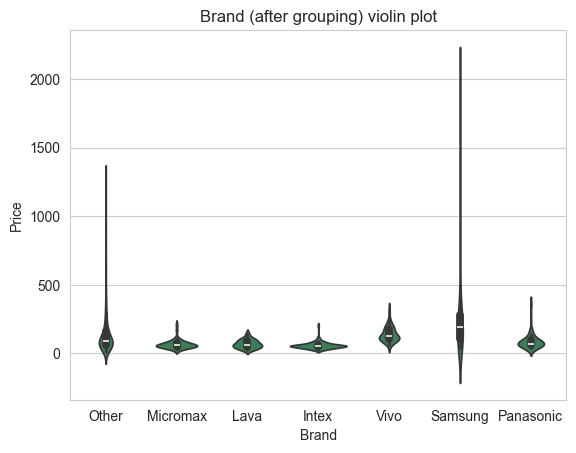

In [24]:
sns.violinplot(x=new_col_train,y=dtf_train['Price'],color="seagreen").set_title("Brand (after grouping) violin plot")

we can see that aside from Samsung (and Other) each brand has its own specific price range

## Model Training

In [25]:
dtf_train = pd.concat([dtf_train, dummy_train], axis=1)
dtf_test = pd.concat([dtf_test, dummy_test], axis=1)

In [26]:
dtf_train = dtf_train.drop("Brand", axis=1)
dtf_test = dtf_test.drop("Brand", axis=1)

In [27]:
X_train = dtf_train.drop(['Name','Model','Price'],axis=1)
X_test = dtf_test.drop(['Name','Model','Price'],axis=1)

y_train = dtf_train['Price']
y_test = dtf_test['Price']

In [28]:
features_model = X_train.columns

In [29]:
model = xgboost.XGBRegressor()
model.fit(X_train[features_model],y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Error Analysis

In [30]:
prediction = model.predict(X_test[features_model])

## Metrics

In [31]:
print(f'r^2 score:{r2_score(y_test,prediction)}')

r^2 score:0.5226881595128583


as we can see, our r^2 score is pretty low, meaning that the model doesn't "explain" the variance.  
Therefore the model's output isn't as predicted (from the features) as we want it to be - the model needs further tuning.

In [32]:
# metrics
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,prediction)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, prediction)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, prediction))))

# residuals
residuals = y_test - prediction
max_error = residuals.abs().max()
print("Max Error:", "{:,.0f}".format(max_error))

Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.478
Mean Absolute Error (Σ|y - pred|/n): 55
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 119
Max Error: 1,391


Follows the r^2 score, we can also see that the other metrics of our model are also pretty bad.  
The mean absolute perc error is significally high: half (!) of the phone price - which translates to 55 USD at average.  
However, the max error shouldn't worry us too much since we know that our target variable is skewed with many outliers.  

Text(0.5, 0, 'Price')

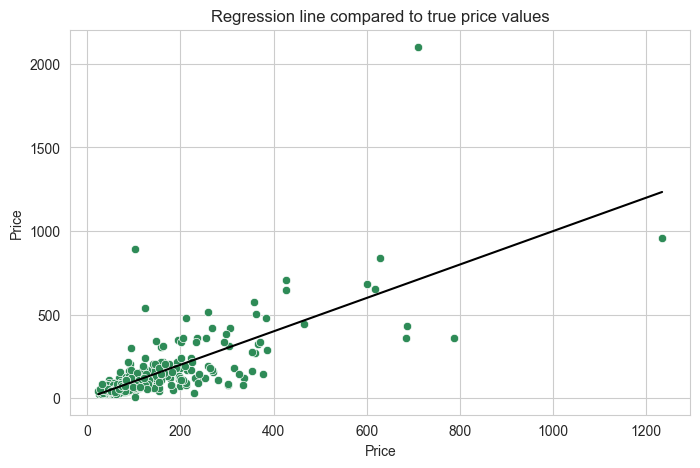

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=prediction,y=y_test,ax=ax,color='seagreen')
sns.lineplot(x=prediction,y=prediction,ax=ax,color='black')
ax.set_title("Regression line compared to true price values")
ax.set_xlabel("Price")

we can see that the max error is indeed at the outliers but we also have high errors on all price ranges.

## Residuals

Text(0, 0.5, 'Count')

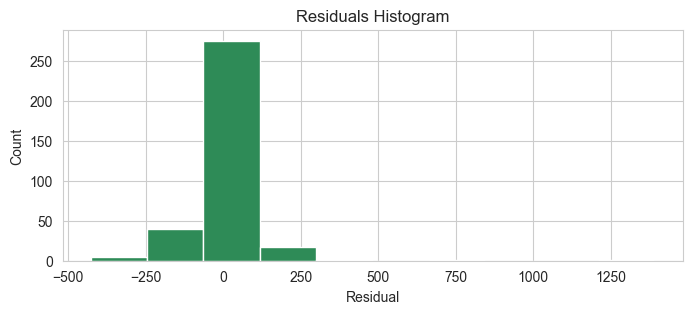

In [34]:
fig, ax = plt.subplots(figsize=(8,3))
residuals.hist(color='seagreen',ax=ax)
ax.set_title("Residuals Histogram")
ax.set_xlabel("Residual")
ax.set_ylabel("Count")

We can see that the model is mostly over pricing the phones.  
From the graph it looks like we are over pricing by a little amount but we need to keep in mind that most of our data are cheap phones so every dollar means a lot percentage wise.

In [35]:
# checking error rate by number of samples
rel_res = residuals/y_test
rel_res = rel_res.abs()
for i in range(10,51,10):
    print(f'Model achieved error less than {i}% in {round(len(rel_res[rel_res<(i/100)])/len(rel_res),4)} of the samples.')

Model achieved error less than 10% in 0.1735 of the samples.
Model achieved error less than 20% in 0.3618 of the samples.
Model achieved error less than 30% in 0.5324 of the samples.
Model achieved error less than 40% in 0.65 of the samples.
Model achieved error less than 50% in 0.7471 of the samples.


## Summary

In conclusion, our model has low scores and high error rates.  
Further feature engineering and model tuning is needed in order to achieve better results.  
Some of the possible needed work are the suggested ideas in the visuals section: remove correlated hardware features, group similar operating systems and split the battery capacity into several bins.